In [1]:
import sys
sys.path.append('/Users/aakash/anaconda3/envs/gis/lib/python3.6/site-packages')
sys.path.append('/Users/aakash/anaconda3/lib/python3.6/site-packages')
import glob
import os
import pandas as pd
import matplotlib.pyplot as plt
import ee
import numpy as np
from datetime import datetime, timedelta

plt.rcParams['figure.figsize'] = [18,16]
ee.Initialize()

In [2]:
# Helpers 

In [3]:
def read_file(filename):
    with open(filename) as f:
        contents = f.readlines()

    data = []
    for line in contents:
        if line[0:1] == "#":
            continue
        else:
            data.append(line)

    headers = [x.replace("Soil Moisture Percent","smp").replace(" ","_") for x in data[0].split(",")]
    cols = [x.strip("\n").split(",") for x in data[1:]]

    df = pd.DataFrame(cols, columns = headers)
    
    return df

def get_site_lat_lons(site_num, stations_csv):
    df = pd.read_csv(stations_csv)
    site = df[df['site_name'].str.contains(site_no)]
    
    lat, lon = site['lat'].values, site['lon'].values
    return lat[0], lon[0]

In [4]:
# EE --> Numpy functions

In [5]:
def array_from_latlon(latlon_obj):
    res = latlon_obj.reduceRegion(reducer=ee.Reducer.toList(),geometry=area,maxPixels=1e8,scale=10)
    data = np.array((ee.Array(res.get("VV")).getInfo()))
    lats = np.array((ee.Array(res.get("latitude")).getInfo()))
    lons = np.array((ee.Array(res.get("longitude")).getInfo()))
    out = make_np_array(data, lats, lons)
    return out   

def make_np_array(data, lats, lons):
    # get data from df as arrays
    lons = np.array(lons)
    lats = np.array(lats)
    data = np.array(data) # Set var here 
                                              
    # get the unique coordinates
    uniqueLats = np.unique(lats)
    uniqueLons = np.unique(lons)

    # get number of columns and rows from coordinates
    ncols = len(uniqueLons)    
    nrows = len(uniqueLats)

    # determine pixelsizes
    ys = uniqueLats[1] - uniqueLats[0] 
    xs = uniqueLons[1] - uniqueLons[0]

    # create an array with dimensions of image
    arr = np.zeros([nrows, ncols], np.float32)

    # fill the array with values
    counter =0
    for y in range(0,len(arr),1):
        for x in range(0,len(arr[0]),1):
            if lats[counter] == uniqueLats[y] and lons[counter] == uniqueLons[x] and counter < len(lats)-1:
                counter+=1
                arr[len(uniqueLats)-1-y,x] = data[counter] # we start from lower left corner
    
    return arr

def get_ims_dates(ims_list):
    imlist = []
    imdates = []
    num_images = len(ims_list.getInfo())

    for i in range (1, num_images):
        latlon = ee.Image.pixelLonLat().addBands(ims_list.get(i))
        imlist.append(array_from_latlon(latlon))
        info_dict = ims.get(i).getInfo()
        date = info_dict['id']
        imdates.append(date)
    
    times = []
    for i in imdates:
        time_idx = i.find("T0")
        ymd = i[time_idx-8:time_idx]
        hms = i[time_idx+1:time_idx+7]
        times.append(datetime.strptime(ymd+hms, '%Y%m%d%H%M%S'))

    return imlist, times


In [6]:
# Find files

In [7]:
csvs = glob.glob("*.csv")
txts = glob.glob("*.txt")
site_file = txts[0]
stations_csv = csvs[0]

In [8]:
# Extract data

In [9]:
site_no = ''.join(c for c in site_file if c.isdigit())
data = read_file(site_file)
lat, lon = get_site_lat_lons(site_no,stations_csv)

In [40]:
# Setup ee Objects

In [10]:
pt = ee.Geometry.Point([lon, lat])
area = pt.buffer(10)

In [11]:
# Set the RS products to be queried, sort from oldest im first

In [12]:
collection = ee.ImageCollection('COPERNICUS/S1_GRD').filterBounds(pt).filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV')).filter(ee.Filter.eq('orbitProperties_pass', 'ASCENDING')).select('VV')
col = collection.filterDate('2014-10-03','2018-10-03')
t = col.sort('system:time_start')
ims = t.toList(t.size())

In [13]:
# get the ims and sort out the dates to match

In [14]:
s1dat, dates = get_ims_dates(ims)

In [15]:
data['Date'] =  pd.to_datetime(data['Date'], format='%Y%m%d %H:%M')
data.set_index('Date', inplace=True)

In [16]:
# Round each startdate to the nearest hour, grab the data that matches that hour 
rzsm = []
ssm = []

for i in dates:
    start = i.replace(second=0, microsecond=0, minute=0, hour=i.hour)+timedelta(hours=i.minute//30)
    df = pd.DataFrame(data.loc[start]).T.astype(np.float)
    rzsm.append(df[df.columns[-1]].values)
    ssm.append(df[df.columns[-3]].values)

In [24]:
mean_sigmas = []

for i in s1dat:
    mean_sigmas.append(np.mean(i))

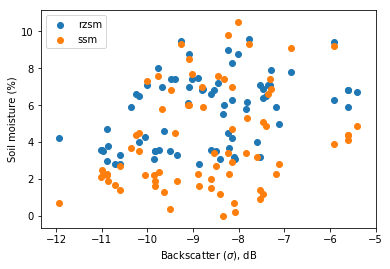

In [25]:
plt.scatter(mean_sigmas, rzsm, label = 'rzsm')
plt.scatter(mean_sigmas, ssm, label = 'ssm')
plt.xlabel("Backscatter ($\sigma$), dB")
plt.ylabel("Soil moisture (%)")
plt.legend()
plt.show()

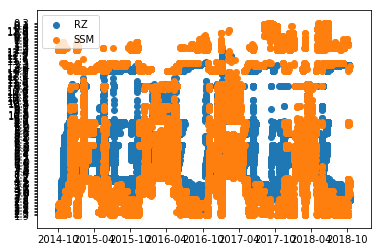

In [23]:
plt.scatter(data.index,data[data.columns[-1]], label = "RZ")
plt.scatter(data.index,data[data.columns[-3]], label = "SSM")
plt.legend()
plt.show()